In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np
import pandas as pd

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data
from data.processing import get_data

from models.seir.seir_testing import SEIR_Testing
from models.seir.seirhd import SEIRHD
from models.seir.seir_movement import SEIR_Movement
from models.seir.seir_movement_testing import SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report

## Load Covid19india Data

In [56]:
dataframes = get_covid19india_api_data()

In [57]:
predictions_dict = {}

## Select Districts to fit on

In [64]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Pune')]

## Perform M1 and M2 fits

Performing m1 fit ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
26  Maharashtra     Pune 2020-05-22        2737.4          5032.8     244.6   
27  Maharashtra     Pune 2020-05-23        2901.2          5336.6     254.2   
28  Maharashtra     Pune 2020-05-24        3034.4          5670.6     263.8   
29  Maharashtra     Pune 2020-05-25        3171.0          5994.8     273.4   
30  Maharashtra     Pune 2020-05-26        3258.4          6304.6     282.2   

    recovered  
26     2050.8  
27     2181.2  
28     2372.4  
29     2550.4  
30     2764.0  
val
          state district       date  hospitalised  total_infected  deceased  \
0  Maharashtra     Pune 2020-05-27        3337.0          6547.4     289.8   
1  Maharashtra     Pune 2020-05-28        3416.0          6855.6     299.0   
2  Maharashtra     Pune 2020-05-29        3503.0          7096.0     306.6   
3  Maharashtra     Pune 2020-05-30        3587.2          7382.2     

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
33  Maharashtra     Pune 2020-05-29        3503.0          7096.0     306.6   
34  Maharashtra     Pune 2020-05-30        3587.2          7382.2     316.0   
35  Maharashtra     Pune 2020-05-31        3699.4          7612.0     323.4   
36  Maharashtra     Pune 2020-06-01        3914.0          8045.0     338.0   
37  Maharashtra     Pune 2020-06-02        3914.0          8045.0     338.0   

    recovered  
33     3286.4  
34     3479.0  
35     3589.2  
36     3793.0  
37     3793.0  
val
 None
100%|██████████| 700/700 [00:27<00:00, 25.60trial/s, best loss: 3.4813778069542325]
best parameters
 {'E_hosp_ratio': 0.3720596553740459, 'I_hosp_ratio': 0.26246846082579434, 'P_fatal': 0.07426153078294659, 'T_inc': 4.124556177974156, 'T_inf': 3.6650302237678467, 'T_recov_severe': 17.370612438960368, 'lockdown_R0': 1.1230459006236007}


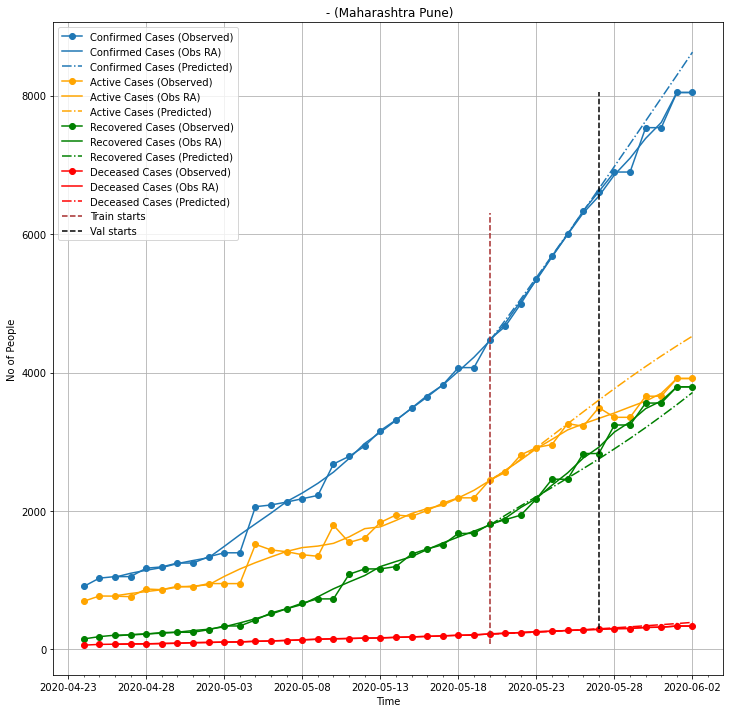

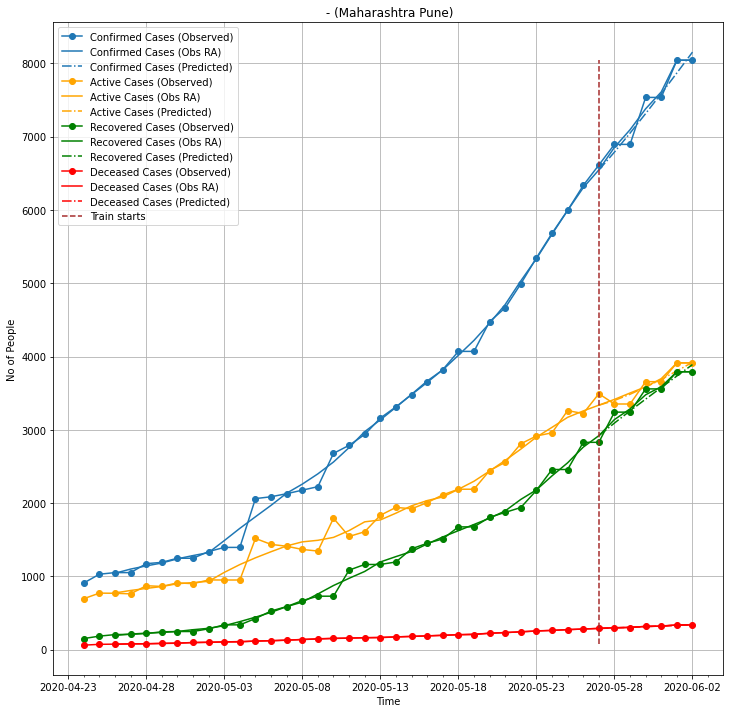

In [85]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, 
        data_from_tracker=True, initialisation='intermediate', num_evals=700, model=SEIR, 
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, num_evals=700,
        data_from_tracker=True, initialisation='intermediate', model=SEIR, 
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [ ]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

### M2 Loss

In [ ]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

## Plot Forecasts

In [ ]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create Report

In [ ]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [ ]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

In [ ]:
write_csv(df_output)